In [1]:
import sys
sys.path.append("../Face_detection")


import pandas as pd
import tensorflow as tf
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt


from PIL import Image
from typing import List
from matplotlib.gridspec import GridSpec
from keras.preprocessing.image import img_to_array, load_img
from keras.models import load_model
from face_detection import detect_face, detect_face_mediapipe
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

2025-07-31 08:10:22.700653: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-31 08:10:22.743017: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-31 08:10:22.743058: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-31 08:10:22.744101: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-31 08:10:22.751120: I tensorflow/core/platform/cpu_feature_guar

In [2]:
df = pd.read_csv('evaluation_dataset.csv', sep=';')

print(df)

     Image  Gender Beard Glasses Haircolor  Nation
0   01.jpg    Male   Yes      No     Brown   White
1   02.jpg    Male   Yes      No     Brown   White
2   03.jpg  Female    No     Yes     Black  Indian
3   04.jpg    Male   Yes      No     Black   Black
4   05.jpg    Male   Yes      No      Gray   White
5   06.jpg    Male    No      No     Black   Black
6   07.jpg  Female    No      No     Black  Indian
7   08.jpg  Female    No      No     Black   Black
8   09.jpg    Male   Yes      No      Gray   Black
9   10.jpg  Female    No     Yes      Gray   White
10  11.jpg    Male   Yes      No     Brown   White
11  12.jpg    Male    No      No     Black   White
12  13.jpg  Female    No      No     Black   White
13  14.jpg    Male   Yes      No     Black   White


# Plot now the images with their actual value and predicted value

In [3]:
images_dir = "Images/"

# Maybe we can parallelize this to make it faster
gender_model_without_pipeline = tf.keras.models.load_model(os.path.join("../Models/Without_DA_Pipeline/", "Gender_classification"))
beard_model_without_pipeline = tf.keras.models.load_model(os.path.join("../Models/Without_DA_Pipeline/", "Beard_classification"))
glasses_model_without_pipeline = tf.keras.models.load_model(os.path.join("../Models/Without_DA_Pipeline/", "Glasses_classification"))
haircolor_model_without_pipeline = tf.keras.models.load_model(os.path.join("../Models/Without_DA_Pipeline/", "Haircolor_classification"))
nation_model_without_pipeline = tf.keras.models.load_model(os.path.join("../Models/Without_DA_Pipeline/", "Nation_classification"))

gender_model_with_pipeline = tf.keras.models.load_model(os.path.join("../Models/With_DA_Pipeline/", "Gender_classification"))
beard_model_with_pipeline = tf.keras.models.load_model(os.path.join("../Models/With_DA_Pipeline/", "Beard_classification"))
glasses_model_with_pipeline = tf.keras.models.load_model(os.path.join("../Models/With_DA_Pipeline/", "Glasses_classification"))
haircolor_model_with_pipeline = tf.keras.models.load_model(os.path.join("../Models/With_DA_Pipeline/", "Haircolor_classification"))
nation_model_with_pipeline = tf.keras.models.load_model(os.path.join("../Models/With_DA_Pipeline/", "Nation_classification"))

2025-07-31 08:10:30.529437: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46733 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:17:00.0, compute capability: 8.6
2025-07-31 08:10:30.531043: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 1008 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:73:00.0, compute capability: 8.6


In [4]:
# Class names for categorical prediction
gender_class_names = ['Female', 'Male']
beard_class_names = ['Yes', 'No']
glasses_class_names = ['Yes', 'No']
haircolor_class_names = ['Black', 'Blond', 'Brown', 'Gray']
nation_class_names = ['Asian', 'Black', 'Indian', 'Other', 'White']

In [5]:
def preprocess_image(img_path: str, target_size=(224, 224)) -> np.ndarray:
    """
    Load and preprocess an image for model prediction.

    Parameters
    ----------
    img_path : str
        Path to the image file.
    target_size : tuple of int, optional
        Desired image size as (height, width). Default is (224, 224).

    Returns
    -------
    img_array : numpy.ndarray
        Preprocessed image array of shape (1, height, width, channels), normalized to [0, 1].
    """
    
    img = load_img(img_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array


def predict_and_display_images(models: List, df: pd.DataFrame, face_detection: bool) -> pd.DataFrame:
    """
    Predict attributes from images and optionally display results.

    Parameters
    ----------
    models : list
        List of trained Keras models in the order:
        [gender_model, beard_model, glasses_model, haircolor_model, nation_model].
    df : pandas.DataFrame
        DataFrame containing image filenames and ground truth labels. Must include columns:
        'Image', 'Gender', 'Beard', 'Glasses', 'Haircolor', 'Nation'.
    face_detection : bool
        If True, detects and crops faces before prediction. If False, uses the whole image.

    Returns
    -------
    df_with_preds : pandas.DataFrame
        DataFrame containing original data and predicted labels for each attribute.
    """
    
    if not os.path.exists(images_dir):
        raise FileNotFoundError(f"Directory {images_dir} doesn't exist!")
        
    predictions = []
    displayed = 0

    for index, row in df.iterrows():
        image_name = row['Image']
        
        #if image_name[:-4] < "11":
        #    continue
        
        image_path = os.path.join(images_dir, image_name)

        if not os.path.exists(image_path):
            print(f"Error: Image {image_path} not found!")
            continue

        if face_detection:
            face = detect_face_mediapipe(image_path)
            if face is None:
                print(f"No face detected in image {image_name}, skipping.")
                continue
            face_rgb = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
            pil_img = Image.fromarray(face_rgb)
            pil_img = pil_img.resize((224, 224))
            img_array = img_to_array(pil_img)
            img_array = img_array / 255.0
            img_array = np.expand_dims(img_array, axis=0)
        else:
            img_array = preprocess_image(image_path)

        gender_pred = models[0].predict(img_array, verbose=0)
        beard_pred = models[1].predict(img_array, verbose=0)
        glasses_pred = models[2].predict(img_array, verbose=0)
        haircolor_pred = models[3].predict(img_array, verbose=0)
        nation_pred = models[4].predict(img_array, verbose=0)

        gender_predicted_labels = (gender_pred > 0.5).astype(int).flatten()
        gender_label = gender_class_names[gender_predicted_labels[0]]
        
        beard_predicted_labels = (beard_pred > 0.5).astype(int).flatten()
        beard_label = beard_class_names[beard_predicted_labels[0]]
        
        glasses_predicted_labels = (glasses_pred > 0.5).astype(int).flatten()
        glasses_label = glasses_class_names[glasses_predicted_labels[0]]
        
        haircolor_label_index = np.argmax(haircolor_pred, axis=1)[0]
        haircolor_label = haircolor_class_names[haircolor_label_index]
        
        nation_label_index = np.argmax(nation_pred, axis=1)[0]
        nation_label = nation_class_names[nation_label_index]
        
        
        predictions.append({
            "Image": image_name,
            "Gender_Pred": gender_label,
            "Beard_Pred": beard_label,
            "Glasses_Pred": glasses_label,
            "Haircolor_Pred": haircolor_label,
            "Nation_Pred": nation_label
        })

        gt_gender = row['Gender']
        gt_beard = row['Beard']
        gt_glasses = row['Glasses']
        gt_haircolor = row['Haircolor']
        gt_nation = row['Nation']

        """
        fig = plt.figure(figsize=(11, 4))
        gs = GridSpec(1, 2, width_ratios=[1, 1.5])

        ax_img = fig.add_subplot(gs[0])
        if face_detection and face is not None:
            ax_img.imshow(face_rgb)
        else:
            ax_img.imshow(load_img(image_path))
        ax_img.axis('off')
        ax_img.set_title(f"Image: {image_name[:-4]}", fontsize=13, pad=10)

        lines = [
            f"Gender:     {gender_label:<8}  (GT: {gt_gender})",
            f"Beard:      {beard_label:<8}  (GT: {gt_beard})",
            f"Glasses:    {glasses_label:<8}  (GT: {gt_glasses})",
            f"Haircolor:  {haircolor_label:<8}  (GT: {gt_haircolor})",
            f"Nation:     {nation_label:<8}  (GT: {gt_nation})"
        ]
        text = "\n".join(lines)

        ax_text = fig.add_subplot(gs[1])
        ax_text.axis('off')
        ax_text.text(
            0.0, 0.5, text,
            fontsize=13,
            verticalalignment='center',
            horizontalalignment='left',
            family='monospace',
            transform=ax_text.transAxes
        )

        plt.tight_layout()
        plt.show()

        displayed += 1
        """
        
    pred_df = pd.DataFrame(predictions)
    df_with_preds = pd.merge(df, pred_df, on="Image", how="inner")

    return df_with_preds

# Prediction of the Images without using the Data Augmentation Pipeline

In [6]:
df_preds_without_pipeline_without_face_detection = predict_and_display_images(
    models=[gender_model_without_pipeline, beard_model_without_pipeline, glasses_model_without_pipeline, haircolor_model_without_pipeline, nation_model_without_pipeline],
    df=df,
    face_detection=False
)

df_preds_without_pipeline_with_face_detection = predict_and_display_images(
    models=[gender_model_without_pipeline, beard_model_without_pipeline, glasses_model_without_pipeline, haircolor_model_without_pipeline, nation_model_without_pipeline],
    df=df,
    face_detection=True
)

2025-07-31 08:12:10.258924: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1753949543.483663   36865 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1753949544.173176   37059 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1753949545.054338   37253 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1753949545.822743   37440 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1753949546.430490   37631 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1753949547.092500   37

# Prediction of the Images with using the Data Augmentation Pipeline

In [7]:
df_preds_with_pipeline_without_face_detection = predict_and_display_images(
    models=[gender_model_with_pipeline, beard_model_with_pipeline, glasses_model_with_pipeline, haircolor_model_with_pipeline, nation_model_with_pipeline],
    df=df,
    face_detection=False
)

df_preds_with_pipeline_with_face_detection = predict_and_display_images(
    models=[gender_model_with_pipeline, beard_model_with_pipeline, glasses_model_with_pipeline, haircolor_model_with_pipeline, nation_model_with_pipeline],
    df=df,
    face_detection=True
)

W0000 00:00:1753949563.945862   42050 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1753949564.580410   42237 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1753949565.423525   42424 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1753949566.186717   42618 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1753949566.801925   42805 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1753949567.400668   42992 inference_feedback_manager.cc:114] Feedback manager 

In [8]:
def plot_confusion_matrix(
    df_preds_one: pd.DataFrame,
    df_preds_one_title: str,
    df_preds_two: pd.DataFrame,
    df_preds_two_title: str
) -> None:
    """
    Plot confusion matrices for multiple classification attributes comparing two prediction DataFrames.

    Parameters
    ----------
    df_preds_one : pandas.DataFrame
        DataFrame containing ground truth and predicted values for the first model/configuration.
    df_preds_one_title : str
        Title for the first set of confusion matrices.
    df_preds_two : pandas.DataFrame
        DataFrame containing ground truth and predicted values for the second model/configuration.
    df_preds_two_title : str
        Title for the second set of confusion matrices.

    Returns
    -------
    None
    """
    
    properties = ["Gender", "Beard", "Glasses", "Haircolor", "Nation"]
    labels_dict = {
        "Gender": ['Female', 'Male'],
        "Beard": ["Yes", "No"],
        "Glasses": ["Yes", "No"],
        "Haircolor": ["Black", "Blond", "Brown", "Gray"],
        "Nation": ["Asian", "Black", "Indian", "Other", "White"]
    }

    for prop in properties:
        print(f"{prop}:")

        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

        cm_without = confusion_matrix(
            df_preds_one[prop], 
            df_preds_one[f"{prop}_Pred"], 
            labels=labels_dict[prop]
        )
        disp_without = ConfusionMatrixDisplay(confusion_matrix=cm_without, display_labels=labels_dict[prop])
        disp_without.plot(ax=axes[0])
        axes[0].set_title(f"{prop} - {df_preds_one_title}")

        cm_with = confusion_matrix(
            df_preds_two[prop], 
            df_preds_two[f"{prop}_Pred"], 
            labels=labels_dict[prop]
        )
        disp_with = ConfusionMatrixDisplay(confusion_matrix=cm_with, display_labels=labels_dict[prop])
        disp_with.plot(ax=axes[1])
        axes[1].set_title(f"{prop} - {df_preds_two_title}")

        plt.tight_layout()
        plt.savefig(f"{prop} - {df_preds_one_title}.pdf", bbox_inches="tight")
        plt.show()

Gender:


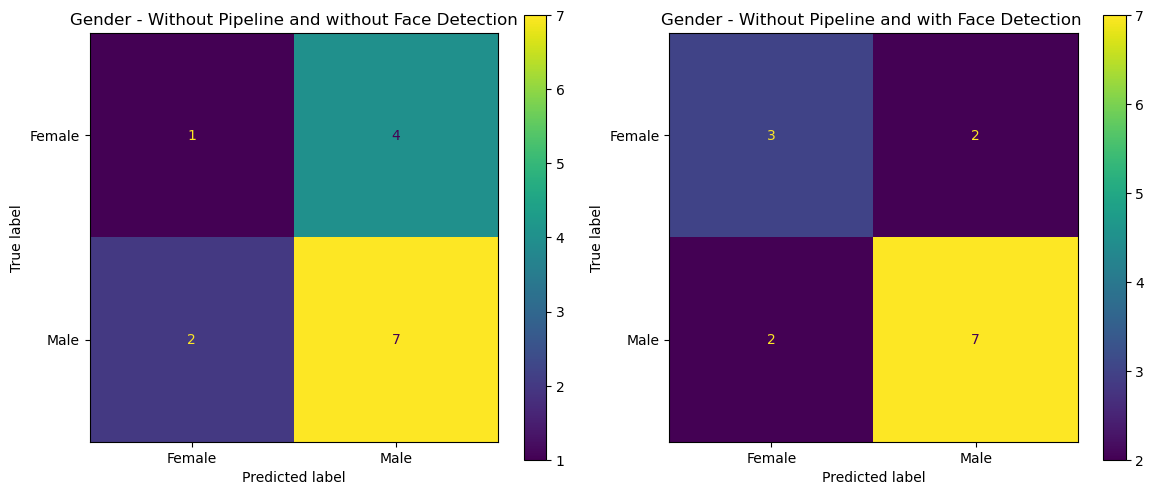

Beard:


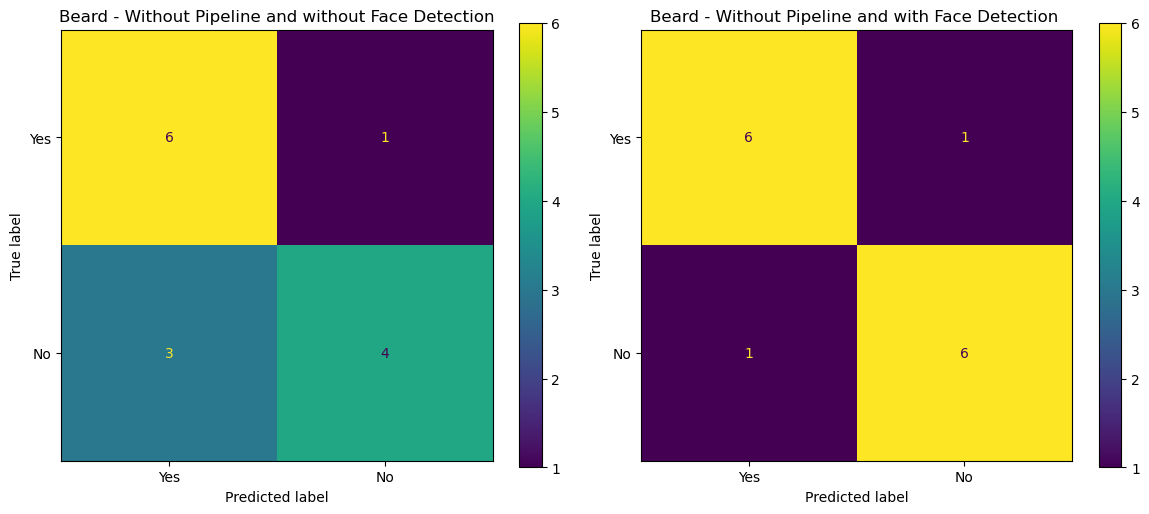

Glasses:


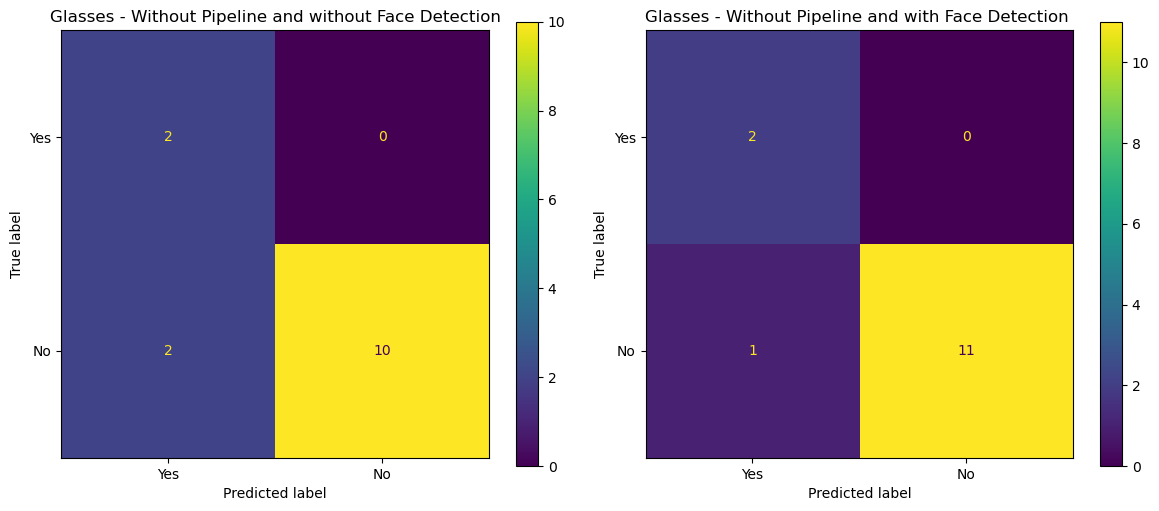

Haircolor:


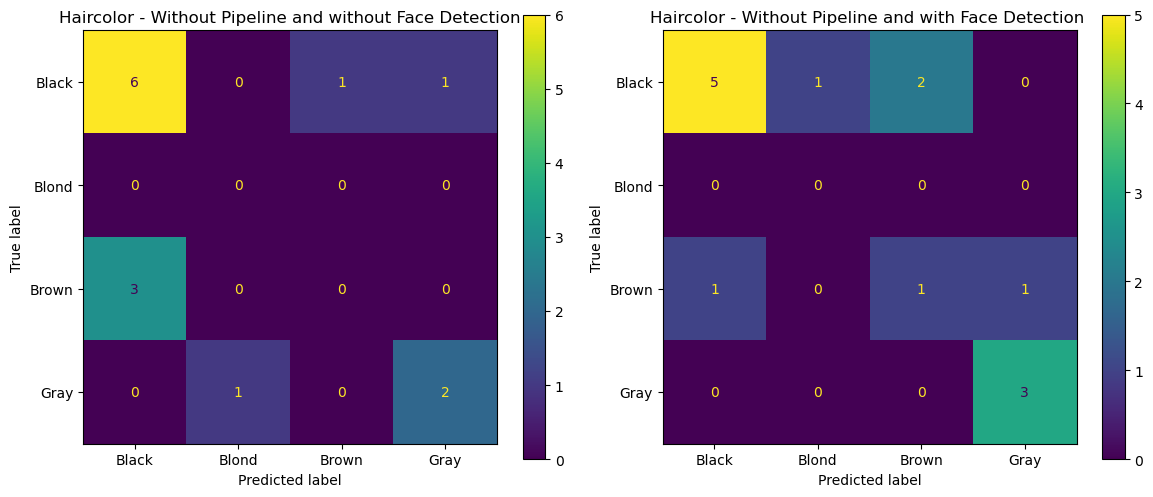

Nation:


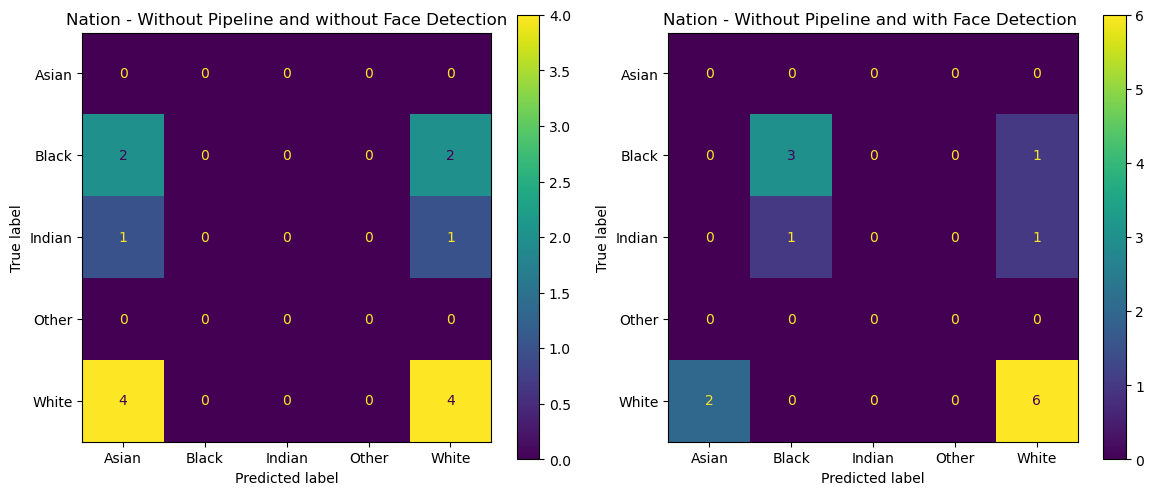

In [9]:
plot_confusion_matrix(df_preds_one=df_preds_without_pipeline_without_face_detection, df_preds_one_title="Without Pipeline and without Face Detection", df_preds_two=df_preds_without_pipeline_with_face_detection, df_preds_two_title="Without Pipeline and with Face Detection ")

Gender:


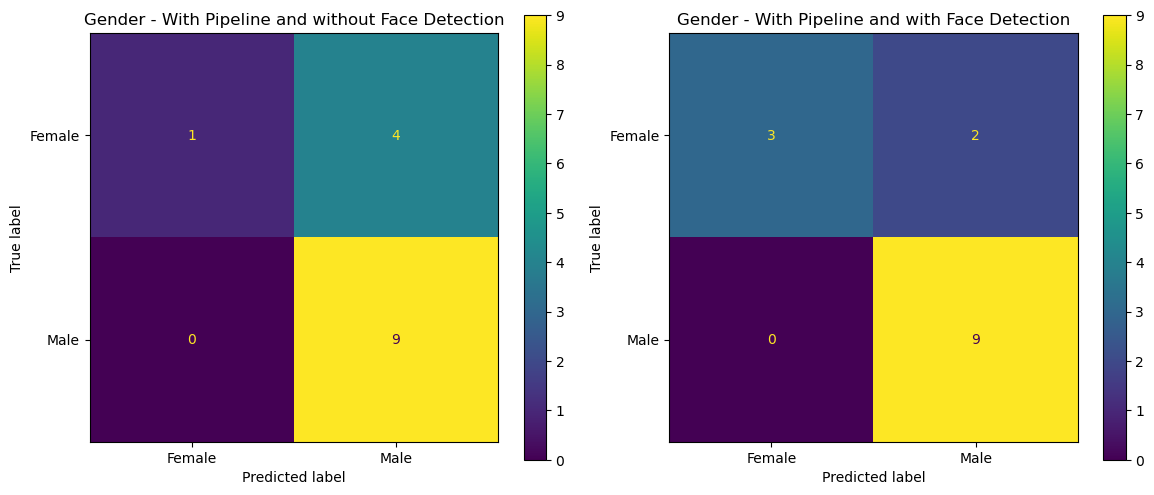

Beard:


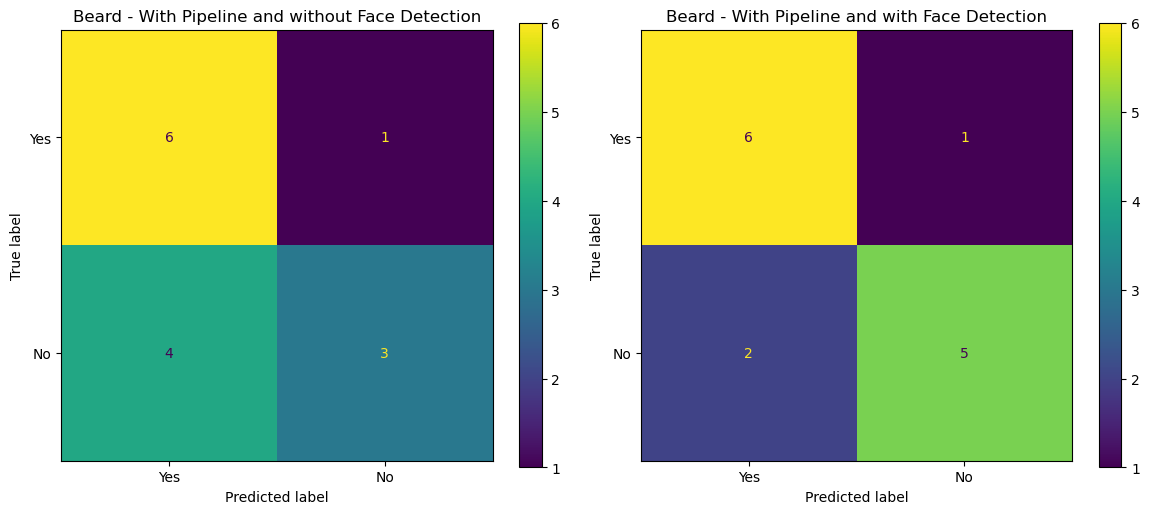

Glasses:


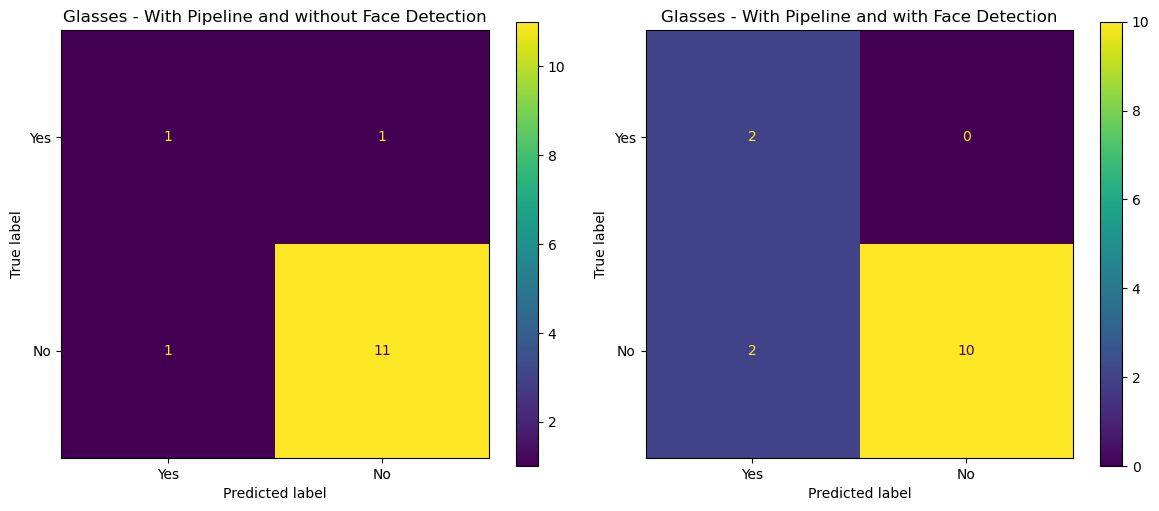

Haircolor:


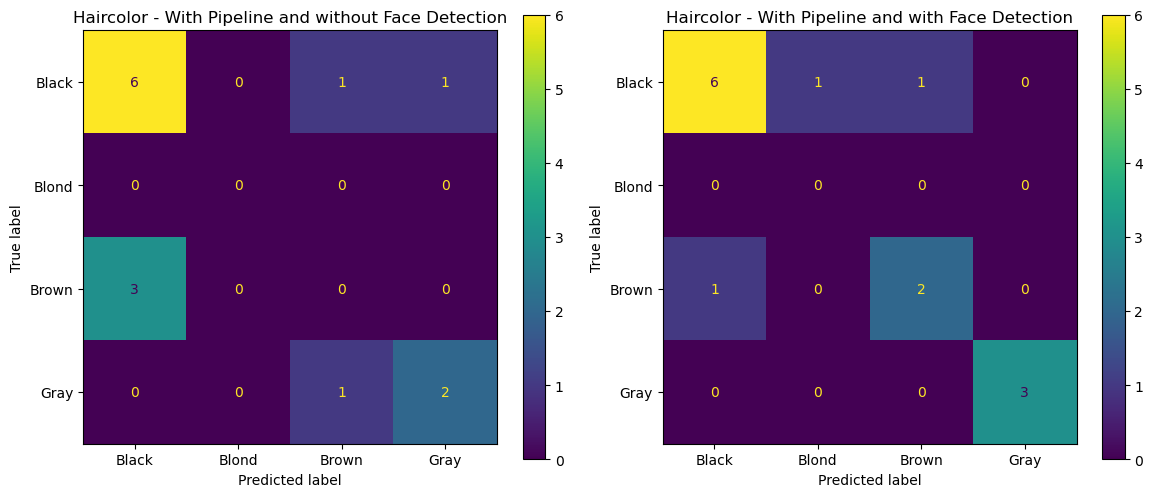

Nation:


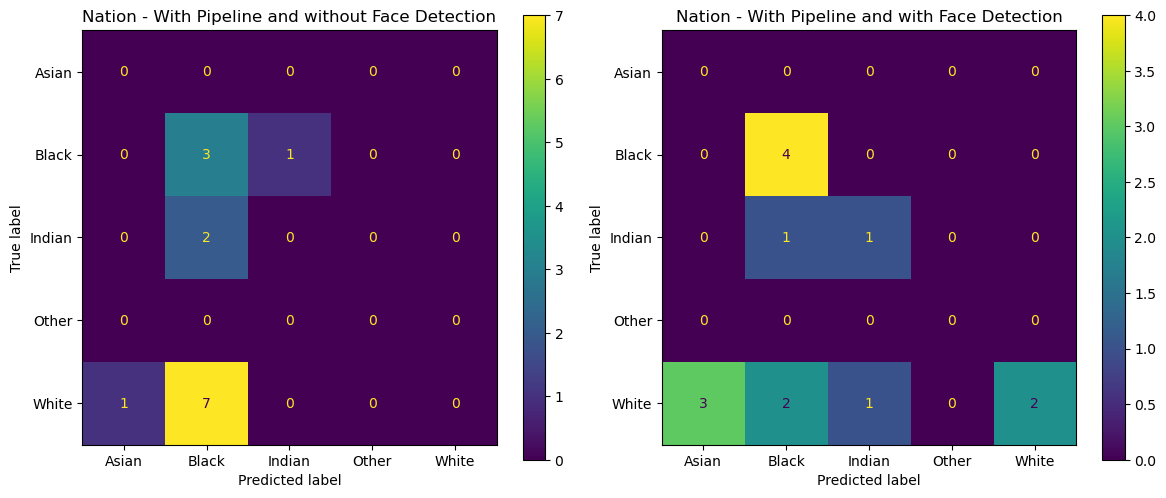

In [10]:
plot_confusion_matrix(
    df_preds_one=df_preds_with_pipeline_without_face_detection, 
    df_preds_one_title="With Pipeline and without Face Detection", 
    df_preds_two=df_preds_with_pipeline_with_face_detection, 
    df_preds_two_title="With Pipeline and with Face Detection"
)

In [11]:
def create_summary_table(df_preds: pd.DataFrame) -> None:
    """
    Generate and print a summary table of classification metrics for multiple attributes.

    Parameters
    ----------
    df_preds : pandas.DataFrame
        DataFrame containing ground truth and predicted values for each attribute.
        Must include columns: 'Gender', 'Beard', 'Glasses', 'Haircolor', 'Nation'
        and their corresponding prediction columns.

    Returns
    -------
    None
    """
    
    properties = ["Gender", "Beard", "Glasses", "Haircolor", "Nation"]
    summary_data = []

    for prop in properties:
        y_true = df_preds[prop]
        y_pred = df_preds[f"{prop}_Pred"]

        report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
        acc = accuracy_score(y_true, y_pred)

        f1_scores = {label: info["f1-score"] for label, info in report.items() if isinstance(info, dict)}
        best_class = max(f1_scores, key=f1_scores.get)
        worst_class = min(f1_scores, key=f1_scores.get)

        summary_data.append({
            "Attribute": prop,
            "Accuracy": round(acc, 2),
            "F1 (macro)": round(report["macro avg"]["f1-score"], 2),
            "Precision (macro)": round(report["macro avg"]["precision"], 2),
            "Recall (macro)": round(report["macro avg"]["recall"], 2),
            "Best class": best_class,
            "Worst class": worst_class
        })

        print(f"\nClassification report for {prop}:")
        print(classification_report(y_true, y_pred, zero_division=0))

    summary_df = pd.DataFrame(summary_data)
    # print(summary_df)
    
    df_report = pd.DataFrame(summary_df).transpose()
    latex_table = df_report.to_latex(float_format="%.2f", caption="Classification Report")
    print(latex_table)

In [12]:
create_summary_table(df_preds=df_preds_without_pipeline_without_face_detection)


Classification report for Gender:
              precision    recall  f1-score   support

      Female       0.33      0.20      0.25         5
        Male       0.64      0.78      0.70         9

    accuracy                           0.57        14
   macro avg       0.48      0.49      0.47        14
weighted avg       0.53      0.57      0.54        14


Classification report for Beard:
              precision    recall  f1-score   support

          No       0.80      0.57      0.67         7
         Yes       0.67      0.86      0.75         7

    accuracy                           0.71        14
   macro avg       0.73      0.71      0.71        14
weighted avg       0.73      0.71      0.71        14


Classification report for Glasses:
              precision    recall  f1-score   support

          No       1.00      0.83      0.91        12
         Yes       0.50      1.00      0.67         2

    accuracy                           0.86        14
   macro avg       0.75

In [16]:
create_summary_table(df_preds=df_preds_with_pipeline_with_face_detection)


Classification report for Gender:
              precision    recall  f1-score   support

      Female       1.00      0.60      0.75         5
        Male       0.82      1.00      0.90         9

    accuracy                           0.86        14
   macro avg       0.91      0.80      0.82        14
weighted avg       0.88      0.86      0.85        14


Classification report for Beard:
              precision    recall  f1-score   support

          No       0.83      0.71      0.77         7
         Yes       0.75      0.86      0.80         7

    accuracy                           0.79        14
   macro avg       0.79      0.79      0.78        14
weighted avg       0.79      0.79      0.78        14


Classification report for Glasses:
              precision    recall  f1-score   support

          No       1.00      0.83      0.91        12
         Yes       0.50      1.00      0.67         2

    accuracy                           0.86        14
   macro avg       0.75